In [134]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import math

from sympy import Point2D

In [158]:
h = 620
w = 620

def PxltoCoord(x, y, zoom, cntr_lat, cntr_lon):
    parallelMultiplier = math.cos(cntr_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = cntr_lat - degreesPerPixelY * (y - h / 2)
    pointLng = cntr_lon + degreesPerPixelX * (x - w / 2)

    return [float(pointLat), float(pointLng)]


# Because of non linear transformation (going from pixel to coordinates), function has to be solved for X and Y
def CoordToPixel(pointLat, pointLon, test_lat, test_lon, zoom):
    parallelMultiplier = math.cos(test_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier

    Y = (test_lat - pointLat) / degreesPerPixelY + 0.5 * h
    X = (pointLon - test_lon) / degreesPerPixelX + 0.5 * w
    return X, Y

In [136]:
def find_specific_lookup(data, search_image, template_name):
    for entry in data:
        if entry["search_image"] == search_image:
            for template in entry["templates"]:
                if template["template"] == template_name:
                    return template
    return None

In [170]:
from matplotlib import image as mpimg

#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/train_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.99908_4.373749.png')
q_img_path = os.path.join(base_path, 'Data/train_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]]) 
            gps = find_specific_lookup(label, '51.99908_4.373749.png', file)
            
            templates.append((q_img[:, :, :3], gps))

In [214]:
def extract_features_for_templates(templates, source_image):
    feature_list = []
    label_list = []
    
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        # good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = query_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])
        
        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 468
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)

In [232]:
def extract_keypoints(templates, source_image):
    feature_list = []
    label_list = []
    src_flat = []
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = dst_pts
        # dst_flat = dst_pts.flatten()
        # input_features = np.concatenate([src_flat, dst_flat])
        # 
        # # Append to feature list
        # feature_list.append(input_features)
        # label_list.append(gps_pixel)  # GPS coordinates of this template image
    # max_len = max(len(features) for features in feature_list)
    # # max_len = 468
    # padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return src_flat

In [233]:
###### DB SCAN

In [215]:
X_train, y_train = extract_features_for_templates(templates, s_img)

(2.3021399974823, 334.0279846191406)
[[  0.   0.   0. ...   0.   0.   2.]
 [  3.   5.   5. ...   2.   3.  21.]
 [ 20.  26.  27. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   2.   6.  13.]
 [ 18.   4.   0. ... 129.  47.  16.]
 [  0.   1.   0. ...  22.  47.  59.]]
[[ 76.1571   272.46384 ]
 [109.1816   169.60735 ]
 [186.55173  429.98245 ]
 [210.43274  406.19083 ]
 [237.6002   113.864   ]
 [278.5339   215.84239 ]
 [278.5339   215.84239 ]
 [282.28284  260.18506 ]
 [282.28284  260.18506 ]
 [287.48947  105.02383 ]
 [295.91425  296.29788 ]
 [295.91425  296.29788 ]
 [304.38733  505.6272  ]
 [314.7073   335.98117 ]
 [339.4381   273.80145 ]
 [349.95227  104.85873 ]
 [357.72232   63.90004 ]
 [360.67523  241.01132 ]
 [378.01968  260.6788  ]
 [397.8579   296.91022 ]
 [402.36783   47.288662]
 [420.9124   256.83817 ]
 [439.97214  561.51166 ]
 [446.27386  332.42456 ]
 [447.4803    52.43979 ]
 [467.39474  221.26195 ]
 [481.97247   29.966978]
 [521.9906   310.56396 ]
 [521.9906   310.56396 ]
 [546.8175

KeyboardInterrupt: 

In [234]:
keypoints_train = extract_keypoints(templates, s_img)

[[362.31973  168.93791 ]
 [ 43.84055  599.8402  ]
 [ 32.682922  78.41174 ]
 [ 32.682922  78.41174 ]
 [410.98825  441.77914 ]
 [584.60657  350.70816 ]
 [169.69308  415.86914 ]
 [ 37.821888  47.53132 ]
 [ 37.852753  42.32914 ]
 [529.9024   189.25668 ]
 [ 40.271595  31.244759]
 [ 43.14943   26.331356]
 [ 43.221252  63.969334]
 [ 44.734314  35.430443]
 [ 48.175514  64.73988 ]
 [ 49.61004   55.547836]
 [ 49.92788   25.494696]
 [ 49.92788   25.494696]
 [ 52.26047   33.91126 ]
 [ 53.602524  27.703066]
 [314.22903  114.636856]
 [ 55.3644    81.9789  ]
 [ 56.25941   59.331306]
 [ 59.60914   55.908142]
 [ 62.40408   79.63857 ]
 [ 62.556168  85.483406]
 [ 64.73138   57.890305]
 [ 66.43317   29.764837]
 [ 66.974815  26.513256]
 [ 67.365166  36.74959 ]
 [235.2336   175.14902 ]
 [ 70.45432   80.48048 ]
 [ 71.59268   81.70823 ]
 [ 71.85623   45.243664]
 [ 75.49684   28.836927]
 [ 75.96216   44.25301 ]
 [243.61302  530.0695  ]
 [ 78.80104   72.75247 ]
 [ 78.630615  82.26575 ]
 [ 78.76802   42.642307]


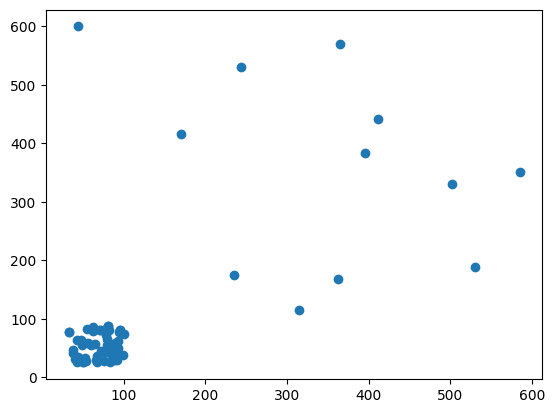

In [238]:
print(keypoints_train)

plt.scatter(keypoints_train[:, 0], keypoints_train[:, 1])

In [243]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

#keypoints_train = extract_keypoints(templates, s_img)
db = DBSCAN(eps=0.5, min_samples=5).fit(keypoints_train)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [244]:
print(n_clusters_, n_noise_, labels)

0 66 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [207]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop, Adam

# Define the model
def build_model(input_size):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(input_size)),
        layers.MaxPooling2D((2, 2)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2)  # Predict latitude and longitude
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.85),  # You can tune the learning rate
              loss='mean_squared_error')
    return model


In [208]:
print(X_train.shape[1])

504


In [209]:
# Initialize and train the model
model = build_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2)


C:\Users\drdur\OneDrive\Desktop\CASSINI Hackathon\CASSINI\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Input 0 of layer "conv2d_2" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 504)

In [193]:
#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/test_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.99908_4.373749.png')
q_img_path = os.path.join(base_path, 'Data/test_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]]) 
            gps = find_specific_lookup(label, '51.99908_4.373749.png', file)
            
            templates.append((q_img[:, :, :3], gps))

In [178]:
def extract_features_for_test(templates, source_image):
    feature_list = []
    label_list = []
    
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        # Extract matched keypoints
        src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = src_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])
        
        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    # max_len = max(len(features) for features in feature_list)
    max_len = 504
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)

In [179]:
X_test, y_test = extract_features_for_test(templates, s_img)

In [180]:
print(X_test.shape)

(300, 504)


In [201]:
from haversine import haversine, Unit
distance = 0
for i, test_input in enumerate(X_test):
    y_trinna = PxltoCoord(y_test[i][0], y_test[i][1], 15, 51.999080, 4.373749)
    # print(test_input.shape)
    point2 = model.predict(test_input.reshape(1, -1))
    # print(point2)
    point2 = PxltoCoord(point2[0][0], point2[0][1], 15, 51.999080, 4.373749)
    # print(point2)
    # print(point2)
    distance += haversine(y_trinna, point2, unit=Unit.METERS)
print(len(X_test))
print(distance/len(X_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━